<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Семинар. Регуляризация в линейных алгоритмах</b></h1>

В этом семинаре мы поговорим об $L_1$- и $L_2$-регуляризации линейной регрессии, а также об ElasticNet. Реализуем линейную регресиию с Lasso-регуляризацией и сравним реализацию с моделью из sklearn.

Зачастую модель машинного обучения обучается на зашумлённых данных, то есть данных с ошибками и случайными отклонениями. Модель машинного обучения, которая обучается на минимизацию функции потерь, не может автоматически понять, где в датасете реальные важные закономерности, а где -- ошибки и случайные совпадения. Нам бы хотелось заставить модель **не переобучаться** под такие проблемы в данных и вычленять только неслучаные закономерности. Иначе, идеально обучившись на датасете с шумом, мы можем получить плохой результат на тестовых данных.

На практике переобучение проявляется в излишней сложности модели. **Регуляризация** -- это метод борьбы с переобучением, который штрафует модель за излишнюю сложность сложность, что позволяет строить более простые (и потому стабильные) зависимости.


Еще одной проблемой, специфичной для линейных моделей, является **мультиколлинеарность**. Как разбиралось на лекции, если оптимальных решений задачи минимизации оказывается бесконечно много, то коэффициенты модели могут принимать какие угодно огромные значения. **Вывод**: необходимо *ограничить величину* коэффициентов модели.

Для линейной модели дополнительные ограничения на веса выполняют роль регуляризации.

Функция потерь для линейной регрессии с регуляризацией выглядит следующим образом:
$$L(\mathbf{w}) = \frac{1}{\ell}\sum_{i=1}^{\ell}(\langle \mathbf{w} , x^i \rangle - y^i)^2 + R(\tilde{ \mathbf{w}}) \rightarrow \min_{w}$$
где
* $x^i = (1, x^i_1, \ldots, x^i_n)$ --- вектор признаков $i$-ого объекта;
* $y^i \in\mathbb{R}$ --- правильный ответ на $i$-ом объекте;
* $\mathbf{w} = (w_0, w_1, \ldots, w_n)$ --- вектор весов ($w_0$ --- свободный член).
* $\tilde {\mathbf{w}} =  (w_1, \ldots, w_n)$ --- вектор весов без свободного члена.

Последнее слагаемое определяет вид регуляризации.
* $L_1$-регуляризация (LASSO, least absolute shrinkage and selection operator), регуляризационное слагаемое равно $$R( \mathbf{\tilde w}) = \lambda|| \mathbf{\tilde {w}}||_1 = \lambda (|w_1| + \ldots + |w_n|);$$
* $L_2$-регуляризация (Ridge), регуляризационное слагаемое равно $$R(\tilde{ \mathbf{w}}) = \lambda||\tilde{ \mathbf{w}}||_2^2 = \lambda(|w_1|^2 + \ldots + |w_n|^2);$$
* ElasticNet -- комбинация двух предыдущих, регуляризационное слагаемое равно $$R(\tilde{ \mathbf{w}}) = \alpha ||\tilde{\mathbf{w}}||_1+ \beta ||\tilde {\mathbf{w}}||_2^2.$$

Обратите внимание, что во всех случаях **коэффициент $w_0$ не участвует в сумме!**


In [1]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

## Lasso-регрессия

В LASSO-регрессии мы штрафуем модель **на сумму модулей всех ее весов**.

**Лосс:** $$L(\mathbf{w}) = \frac{1}{\ell} ||X\mathbf{w} - \mathbf{y}||^2_2 + \lambda ||\tilde{\mathbf{w}}||_1,$$ где $\lambda$ -- гиперпараметр, отвечающий за степень регуляризации.

В привычном понимании:

**Лосс:** $$L(\mathbf{w}) = \frac{1}{\ell}\sum_{i=1}^{\ell}\left(\sum_{j=0}^{n} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{n}|w_j|$$



**Градиент:**
$$
\frac{\partial{L}}{\partial{\mathbf{w}}}
= \frac{2}{\ell}\cdot X^T(X\mathbf{w} - \mathbf{y}) + \lambda (0, \mathrm{sign}(w_1), \ldots, \mathrm{sign}(w_n))^T.
$$

Будем считать, что $|\cdot|$ -- дифференцируемая функция, ее производной является $sign(\cdot)$.


In [2]:
def soft_sign(x, eps=1e-7):
    if abs(x) > eps:
        return np.sign(x)
    return x / eps

np_soft_sign = np.vectorize(soft_sign)


class MyLassoRegression(object):
    def __init__(self, C=1):
        self.coef_ = None
        self.intercept_ = None
        self.C = C

    def regularization_term(self, weights):
        signs =  np.np_soft_sign(weights) # YOUR CODE. Calculate soft signs of weights  # [n+1, 1]
        signs[0] = 0  # Не нужно регуляризовывать по свободному члену
        return signs

    def grad(self, X, y, weights):
        y_pred = (X @ weights)  # [l, 1]

        basic_term =  (2. / (X.shape[0])) * X.T @ (y_pred - y) # YOUR CODE. Calulate basic term of loss  # [n+1, 1]

        regularization_term = self.regularization_term(weights)  # [n+1, 1]

        return basic_term + self.C * regularization_term  # [n+1, 1]


    def fit(self, X, y, max_iter=100, lr=0.1):
        # Принимает на вход X, y и вычисляет веса по данной выборке.
        # Не забудьте про фиктивный признак, равный 1!
        X = np.array(X)
        y = np.array(y)
        assert len(y.shape) == 1 and len(X.shape) == 2
        assert X.shape[0] == y.shape[0]

        y = y[:, np.newaxis]

        l, n = X.shape

        # Добавляем признак из единиц
        X_train = np.hstack([np.ones([l, 1]), X])  # [ell, n + 1]

        # Инициализируем веса
        weights = np.random.randn(n + 1, 1)

        losses = []

        for iter_num in range(max_iter):
            # calculate grad
            grad = self.grad(X_train, y, weights)
            # update weights
            weights -= grad * lr / ((iter_num + 1) ** 0.5)

            # calculate loss
            loss = np.mean((X_train @ weights - y) ** 2) + self.C * np.sum(np.abs(weights[1:]))
            losses.append(loss)

        # assign coef, intersept
        self.coef_ = weights[1:]
        self.intercept_ = weights[0]

        return losses


    def predict(self, X):
        X = np.array(X)
        y_pred = X @ self.coef_ + self.intercept_

        return y_pred

Протестируем нашу функцию на одномерной регрессии.

In [3]:
def linear_expression(x):
    return 5 * x + 6

In [4]:
from sklearn.model_selection import train_test_split

objects_num = 50
X = np.linspace(-5, 5, objects_num)
y = linear_expression(X) + np.random.randn(objects_num) * 5

# выделим половину объектов на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

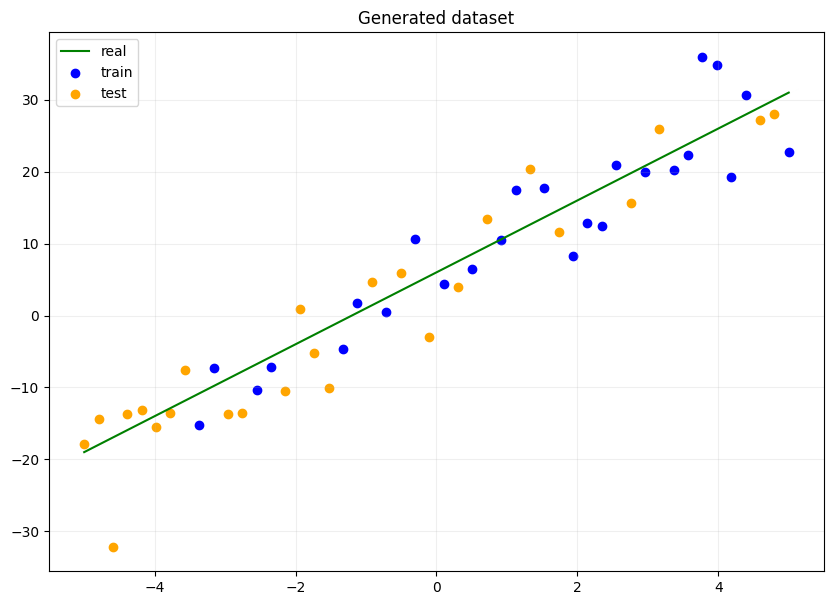

In [5]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [6]:
regressor = MyLassoRegression()

losses = regressor.fit(X_train[:, np.newaxis], y_train)

predictions = regressor.predict(X_test[:, np.newaxis])

AttributeError: module 'numpy' has no attribute 'np_soft_sign'

In [ ]:
regressor.coef_, regressor.intercept_

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(X, linear_expression(X), label='real', c='g')
plt.plot(X, regressor.predict(X[:, np.newaxis]))

plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

## Загрузка датасета
Загрузим набор данных, с которым мы будем работать. В библиотеке scikit-learn есть множество тренировочных наборов данных для освоения и проверки методов машинного обучения. Мы будем работать с датасетом Diabetes. Этот датасет содержит данные о развитии диабета у пациента. Всего в датасете 10 признаков.

<img src="https://drive.google.com/uc?id=19oN1ydcPobFRKc6Bx6Bf8tLVmI4Kh4g4" width="400">

Стандартные наборы данных в scikit-learn находятся в модуле sklearn.datasets.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes

In [ ]:
data = load_diabetes()

print(data['DESCR'])

### Выделение данных

Выделим матрицу объекты-признаки в переменную $X$, правильные ответы --- в переменную $y$. Используем библиотеку pandas. Для отображения информации о наборе данных используем функцию pd.describe, которая отображает полезные статистики из набора: средние значения признаков, минимум, максимум, медиану и др.

In [ ]:
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']

X.describe()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled =  # YOUR CODE. Fit and apply scaler
X_test_scaled =  # YOUR CODE. Apply scaler

In [ ]:
# YOUR CODE. Verify that scaler worked OK

In [ ]:
model = MyLassoRegression(C=0.001)
losses = model.fit(X_train_scaled, y_train)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(losses, label='loss')
plt.legend(fontsize=14)
plt.xlabel('iter', fontsize=14)
plt.grid()

In [ ]:
plt.figure(figsize=(20, 8))
plt.bar(X.columns, model.coef_.ravel())

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_train_prediction = model.predict(X_train_scaled)
y_test_prediction = model.predict(X_test_scaled)

print(f'Train MSE: {mean_squared_error(y_train, y_train_prediction)}')
print(f'Test MSE: {mean_squared_error(y_test, y_test_prediction)}')

In [ ]:
model.coef_, model.intercept_

## Величина весов в зависимости от коэффициента регуляризации

In [ ]:
reg_coefs = np.linspace(10, 100, 50)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    lasso_regressor = MyLassoRegression(C=C)
    lasso_regressor.fit(X_train_scaled, y_train, lr=0.05, max_iter=5000)
    weights = np.hstack((weights, lasso_regressor.coef_.reshape(-1, 1)))

In [ ]:
plt.figure(figsize=(15,8))

for weights_for_feature, column_name in zip(weights, X.columns):
    plt.plot(reg_coefs, weights_for_feature, label=f'weights of feature {column_name}')
plt.legend()
plt.show()

Построим такие же графики для реализации из sklearn:

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
reg_coefs = np.linspace(5, 50, 50)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    lasso_regressor = Lasso(alpha=C)
    lasso_regressor.fit(X_train_scaled, y_train)
    weights = np.hstack((weights, lasso_regressor.coef_.reshape(-1, 1)))

In [ ]:
plt.figure(figsize=(15,8))

for weights_for_feature, column_name in zip(weights, X.columns):
    plt.plot(reg_coefs, weights_for_feature, label=f'weights of feature {column_name}')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

# 2.1. Ridge регрессия (L2-регуляризация)

В ridge мы штрафуем модель также на сумму квадратов всех ее весов, таким образом:

**Лосс:**
$$L(\mathbf{w}) = ||X\mathbf{w} - \mathbf{y}||^2_2 + \lambda||\mathbf{\tilde{w}}||^2_2 = \sum_{i=1}^{\ell}\left(\sum_{j=0}^{n} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{n}w_j^2,$$
где $\lambda$ --- гиперпараметр, отвечающий за степень регуляризации.

Что стоит сказать про значения признаков? Они должны быть стандартизованы для одинаковых штрафов относительно друг друга! (используется связка с `sklearn.preprocessing.StandardScaler`)

Сравнение с графиками для Ridge-регрессии:

In [ ]:
from sklearn.linear_model import Ridge

reg_coefs = np.linspace(1, 10000, 100)

weights = np.empty((len(X.columns), 0))
for C in reg_coefs:
    ridge_regressor = Ridge(C)
    ridge_regressor.fit(X_train_scaled, y_train)
    weights = np.hstack((weights, ridge_regressor.coef_.reshape(-1, 1)))

In [ ]:
plt.figure(figsize=(15,8))

for weights_for_feature, column_name in zip(weights, X.columns):
    plt.plot(reg_coefs, weights_for_feature, label=f'weights of feature {column_name}')
plt.legend()
plt.show()

Различия между $L_1$- и $L_2$-регуляризациями:

- Lasso **сложнее обучать** из-за отсутствия аналитического решения
- В Lasso появляется **зануление весов** для некоторых признаков

## Для самостоятельного изучения: реализация Ridge-регрессии

Аналогично предыдущим заданиям нужно рассчитать значение градиента $\displaystyle\frac{\partial{L}}{\partial{\mathbf{w}}}$.

**Градиент:**
$$
\frac{\partial{L}}{\partial{\mathbf{w}}}
= \frac{2}{\ell}\cdot X^T(X\mathbf{w} - \mathbf{y}) + 2\lambda \cdot (0, w_1, \ldots, w_n)^T.
$$


In [ ]:
class MyRidgeRegression(object):
    def __init__(self, C=1):
        self.coef_ = None
        self.intercept_ = None
        self.C = C

    def regularization_term(self, weights):
        outp = 2 * weights.copy()
        outp[0] = 0  # Не нужно регуляризовывать по свободному члену
        return outp

    def grad(self, X, y, weights):
        y_pred = (X @ weights)  # [ell, 1]

        basic_term = 2. / X.shape[0] * (X.T @ (y_pred - y))

        regularization_term = self.regularization_term(weights)

        return basic_term + self.C * regularization_term


    def fit(self, X, y, max_iter=100, lr=0.1):
        # Принимает на вход X, y и вычисляет веса по данной выборке.
        # Не забудьте про фиктивный признак, равный 1!
        X = np.array(X)
        y = np.array(y)
        assert len(y.shape) == 1 and len(X.shape) == 2
        assert X.shape[0] == y.shape[0]

        y = y[:, np.newaxis]

        l, n = X.shape

        # Добавляем признак из единиц
        X_train = np.hstack([np.ones([l, 1]), X])  # [l, n+1]

        # Инициализируем веса
        weights = np.random.randn(n+1, 1)

        losses = []

        for iter_num in range(max_iter):
            # calculate grad
            grad = self.grad(X_train, y, weights)
            # update weights
            weights -= grad * lr / ((iter_num + 1) ** 0.5)

            # calculate loss
            loss = np.mean((X_train @ weights - y) ** 2) + self.C * np.sum(np.abs(weights[1:]))
            losses.append(loss)

        # assign coef, intersept
        self.coef_ = weights[1:]
        self.intercept_ = weights[0]

        return losses


    def predict(self, X):
        X = np.array(X)
        y_pred = X @ self.coef_ + self.intercept_

        return y_pred

Давайте подробно разберем строку кода:

np_soft_sign = np.vectorize(soft_sign)
Что такое np.vectorize?

np.vectorize — это функция из библиотеки NumPy, которая позволяет упрощать операции над массивами, применяя указанную функцию к каждому элементу массива.

Зачем это нужно?

Когда мы пишем функцию, такую как soft_sign, она принимает одно значение (например, число, float или int) и возвращает знак этого числа либо возвращает значение, нормализованное по маленькому значению eps. Например, для одного элемента это может выглядеть так:

result = soft_sign(0.01)  # Вернет 1.0, если 0.01 > 1e-7
Однако если вам нужно применить эту функцию к массиву (например, к массиву весов), вам нужно либо написать цикл, чтобы снова и снова вызывать soft_sign для каждого элемента, либо использовать векторизованную версию.

Как работает np.vectorize?

Когда мы используем np.vectorize, он создает новую функцию, которая может принимать вектор (или массив) в качестве входных данных, и автоматически применяет исходную функцию soft_sign ко всем элементам массива.

Пример использования np.vectorize:

import numpy as np

def example_function(x):
    return x ** 2

# Создаем векторизованную версию функции
vectorized_function = np.vectorize(example_function)

# Применяем векторизованную функцию к массиву
array = np.array([1, 2, 3, 4])
result = vectorized_function(array)

# result будет [1, 4, 9, 16]
print(result)
Применение к вашему коду

В вашем случае np_soft_sign — это векторизованная версия функции soft_sign, которая позволяет применять ее к массивам весов:

signs = np_soft_sign(weights)  # weights - это массив (например, [w_0, w_1, ..., w_n])
После этого signs будет массивом, где каждая ячейка содержит "мягкий знак" соответствующего элемента из weights. Например, если weights = [0.01, -0.001, 0.15], то после применения np_soft_sign к этому массиву мы получим массив с знаками или нормализованными значениями в зависимости от условий в функции soft_sign.

Заключение

Использование np.vectorize упрощает ваши операции с массивами и позволяет вам писать более чистый и лаконичный код, избегая необходимости явно использовать циклы для обработки данных. Это особенно полезно в контексте машинного обучения и работы с большими наборами данных, так как производительность вашего кода может значительно повыситься за счет того, что NumPy оптимизирован для работы с массивами.

Давайте подробно разберем функцию soft_sign и объясним, почему в ней используется проверка на значение:

def soft_sign(x, eps=1e-7):
    if abs(x) > eps:
        return np.sign(x)
    return x / eps
Основная цель функции soft_sign

Функция soft_sign предназначена для определения "мягкого знака" (soft sign) числа. В контексте регуляризации L1 в Lasso-регрессии важно, чтобы функция не только возвращала знак числа (т.е. -1, 0 или 1), но также обрабатывала значения, близкие к нулю, чтобы предотвратить проблемы в процессе оптимизации.

Разбор каждого элемента функции

abs(x) > eps:

Это условие проверяет, является ли абсолютное значение числа x достаточно большим (больше чем eps, где eps обычно равно (1 \times 10^{-7})).
Если x является довольно малым (например, 0.0001), то оно не будет рассматриваться как "значимое" значение. Это важно, так как вес, близкий к нулю, не должен вносить значительный вклад в регуляризацию, чтобы не влиять на обучение модели.
np.sign(x):

Если абсолютное значение x больше eps, то функция возвращает обычный знак числа с помощью np.sign, который:
Возвращает 1, если x больше 0.
Возвращает -1, если x меньше 0.
Возвращает 0, если x равно 0.
Это будет основной логикой, которая позволит нам получить "значимый" знак.
return x / eps:

Если x близок к 0 (меньше eps по абсолютному значению), функция возвращает x, деленное на eps.
Это деление помогает предотвратить проблемы при вычислениях и обеспечивает более стабильную работу алгоритма. Например, при использовании этого значения для обновления весов, малые значения (которые могли бы быть просто сведены к нулю) всё же будут делиться на очень малое значение, что предотвратит деление на ноль в других частях алгоритма.
Зачем это нужно?

Стабильность вычислений:

Когда значения весов становятся очень маленькими (но не нулевыми), они могут вызывать проблемы при обучении модели, включая числовые ошибки или "подсчет" их как нулевые значения. Учитывание небольших величин с помощью eps позволяет избежать этих проблем.
Регуляризация:

В контексте Lasso-регрессии цель состоит в том, чтобы некоторые веса могли быть занулены (отклонены), но при этом имелась возможность остановиться, если они ближе к нулю. Это "мягкое" округление позволяет некоторым весам быть маленькими, но не равными нулю, тем самым оставляя возможность для адаптации и улучшения модели в будущем.
Пример работы функции soft_sign

Для лучшего понимания, давайте проведем несколько примеров применения функции:

# Примеры значений
print(soft_sign(0.1))     # Выведет 1.0 (так как 0.1 > 1e-7)
print(soft_sign(-0.5))    # Выведет -1.0 (так как -0.5 > 1e-7)
print(soft_sign(0.0000001)) # Выведет 1.0 / 1e-7 = 1000000.0 (так как 0.0000001 < 1e-7)
print(soft_sign(0))       # Выведет 0.0 (так как 0 < 1e-7)
Как видно из этих примеров, функция soft_sign обрабатывает значения по-разному в зависимости от их абсолютного значения. Это обеспечивает контроль над тем, как модель будет реагировать на очень малые значения, что является важным аспектом при реализации Lasso-регрессии.

С - значение силы регулизации

In [13]:

X = np.array([[1, 2],
              [3, 4],
              [5, 6]])
l, n = X.shape
X_train = np.hstack([np.ones([l, 1]), X]) 
X, X_train

(array([[1, 2],
        [3, 4],
        [5, 6]]),
 array([[1., 1., 2.],
        [1., 3., 4.],
        [1., 5., 6.]]))